In [1]:
import pandas as pd
import os, sys
import numpy as np

import torch
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../..')))
from utils.prediction_utils import *

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)


In [2]:
# Load your data using the get_data function
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling"
X, y = get_data("mm", base_dir, sample_rate=0.3)

# Combine X and y into a single DataFrame for convenience
df = pd.concat([X, y], axis=1)
df.info()

# Ensure dtype columns are of integer type
X = X.astype({"dtype_16": int, "dtype_32": int, "dtype_b16": int})
X = X.query("dtype_32")


100%|██████████| 72/72 [00:29<00:00,  2.47it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374256 entries, 0 to 374255
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   n          374256 non-null  int64  
 1   m          374256 non-null  int64  
 2   p          374256 non-null  int64  
 3   gflops     374256 non-null  float64
 4   dtype_16   374256 non-null  bool   
 5   dtype_32   374256 non-null  bool   
 6   dtype_b16  374256 non-null  bool   
 7   time       374256 non-null  float64
dtypes: bool(3), float64(2), int64(3)
memory usage: 15.3 MB


In [13]:
def get_dtype_bytes(row):
    if row['dtype_32']:
        return 4
    elif row['dtype_16']:
        return 2
    elif row['dtype_b16']:
        return 2
    else:
        raise ValueError("Unknown dtype in row.")

def get_dtype_peak_fp(row):
    # 156 for tf32.
    if row['dtype_32']:
        return 19.5
    elif row['dtype_16']:
        return 312
    elif row['dtype_b16']:
        return 312
    else:
        raise ValueError("Unknown dtype in row.")

factor = 0.75
df["peak_gflops_per_ms"] = df.apply(get_dtype_peak_fp, axis=1) * factor

df["memory_accesses"] = (
    df["n"] * df["m"] + df["m"] * df["p"] + df["n"] * df["p"]
) * df.apply(get_dtype_bytes, axis=1) / 1e9  # in GB

# Define beta (DRAM bandwidth in GB/ms)
beta = 2.03904

df["time_hat"] = np.maximum(df["gflops"] / df["peak_gflops_per_ms"], df["memory_accesses"] / beta)

Mean Squared Error: 1136.7050201041154
MAPE: 0.4189270440780362
R-squared: 0.9200937402263865


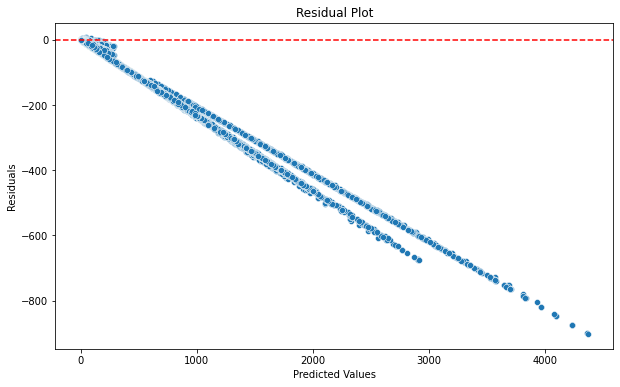

In [14]:
get_r2_score(df["time"], df["time_hat"])
plot_residuals(df["time"], df["time_hat"])

Mean Squared Error: 1136.7082921891458
MAPE: 0.444012093786049
R-squared: 0.9200935102106199


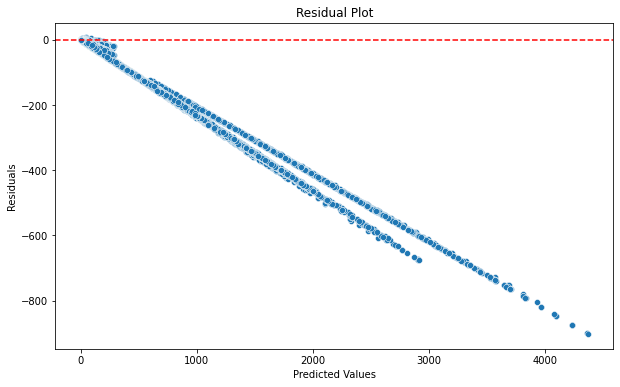

In [15]:
df["time_hat"] = df["gflops"] / df["peak_gflops_per_ms"]

get_r2_score(df["time"], df["time_hat"])
plot_residuals(df["time"], df["time_hat"])

Mean Squared Error: 0.13604484074913337
MAPE: 0.46825644629503815
R-squared: 0.9472186561681072


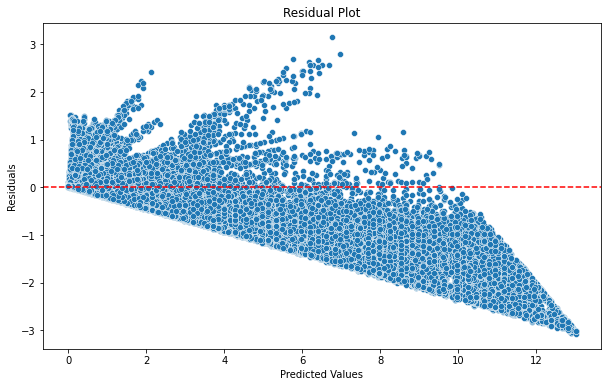

In [12]:
# MSE is significantly smaller, but MAPE is still very high.

small = df.query("time < 10")
get_r2_score(small["time"], small["time_hat"])
plot_residuals(small["time"], small["time_hat"])